In [1]:
# !pip install learn2learn
# !pip install torchmeta
import warnings
warnings.filterwarnings("ignore")
import torch
import utils
import model as MODEL
import train as TRAIN
import matplotlib.pyplot as plt
import epoch
from google.colab import drive
import time
import random
drive.mount('/content/drive')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if __name__ == '__main__':
    Quincy = False ## set true to run Quincy's model
    if Quincy ==True: ## param search in this file doe snot support this 
        Params = {'datasize':96,'nways':32,'kshots':1,'in_channels':3,
                'num_classes':45,'hidden_size':2, "innerStep":.0006,
                'MetaLR':.0006,"number_of_tasks":1, "Order":True,"outerVSinner": 1,
                "epoch":50,'aug':True, 'trainvalSplit':.2,'traintestSplit': .8, 'Quincy':True, 'Alex':False,'mercer':False,'transferLR':.0006,'freeze':True,'path':'/content/drive/MyDrive/'}
    else:
        Params = {'datasize': 96, 'nways': 5, 'kshots': 1, 'in_channels': 3, 'num_classes': 45,
                  'hidden_size': 2, 'innerStep': 0.001, 'MetaLR': 0.0005, 'number_of_tasks': 2,
                  'Order': False, 'outerVSinner': 1, 'epoch': 20, 'aug': True, 'Img_size': 96, 
                  'bs': 32, 'c_dim': 45, 'trainsz': 4725, 'trainvalSplit': 0.2, 'traintestSplit': 0.8, 
                  'Quincy': False, 'Alex': False, 'DataSeenPerEpoch': 4720,'mercer':False,'transferLR':.0006,'freeze':False,'path':'/content/drive/MyDrive/'}
    # print('Getting data')
    Params['path']= '/content/drive/MyDrive/'
    train_tasks,val_loader,test_loader,Params,trainset,ytrain=utils.colabgetdata(Params)
    


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


epoch: 0 val accuracy:  13.621794700622559  topk:  29.887819290161133
epoch: 1 val accuracy:  18.75  topk:  35.41666567325592
epoch: 2 val accuracy:  18.269229888916016  topk:  38.942307233810425
epoch: 3 val accuracy:  19.55128288269043  topk:  38.942307233810425
epoch: 4 val accuracy:  20.83333396911621  topk:  41.34615361690521
epoch: 5 val accuracy:  23.076923370361328  topk:  43.349358439445496
epoch: 6 val accuracy:  25.320512771606445  topk:  45.993590354919434
epoch: 7 val accuracy:  24.038461685180664  topk:  47.516027092933655
epoch: 8 val accuracy:  29.086538314819336  topk:  48.076921701431274
epoch: 9 val accuracy:  27.48397445678711  topk:  49.27884638309479
epoch: 10 val accuracy:  27.7243595123291  topk:  49.03846085071564
epoch: 11 val accuracy:  30.769229888916016  topk:  52.483975887298584
epoch: 12 val accuracy:  29.647436141967773  topk:  52.40384340286255
epoch: 13 val accuracy:  29.40705108642578  topk:  51.682692766189575
epoch: 14 val accuracy:  30.128204345703

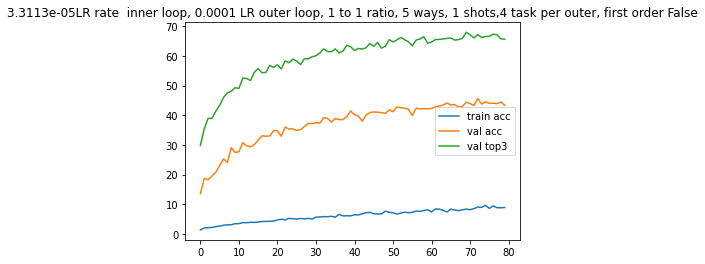

test acc:  42.804954528808594  testtopk:  64.73554372787476
test acc:  42.804954528808594  testtopk:  64.73554372787476
UCmercer
doing Alex's model
epoch: 0 val accuracy:  32.8125  topk:  59.375
epoch: 1 val accuracy:  25.0  topk:  57.8125
epoch: 2 val accuracy:  37.5  topk:  59.375


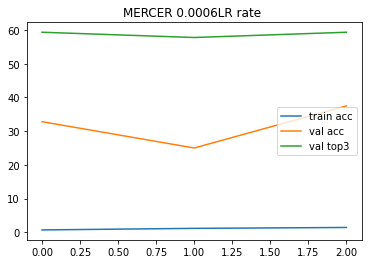

test acc:  37.86057662963867  testtopk:  66.28605723381042


In [2]:
Params= {'Training loss': 222.16639709472656, 'Training Error Rate': 0.3610169589519501, 'Validation topk': 0.5713140964508057, 'Validation Error Rate': 0.37419870495796204, 'onEpoch': 19, 'datasize': 96, 'nways': 5, 'kshots': 1, 'in_channels': 3, 'num_classes': 45, 'hidden_size': 2, 'innerStep': 3.3113e-05, 'MetaLR': 0.0001, 'number_of_tasks': 4, 'Order': False, 'outerVSinner': 1, 'epoch': 80, 'aug': True, 'Img_size': 96, 'bs': 32, 'c_dim': 45, 'trainsz': 4725, 'trainvalSplit': 0.2, 'traintestSplit': 0.8, 'Quincy': False, 'Alex': False, 'DataSeenPerEpoch': 4720, 'mercer': False, 'transferLR': 0.0006, 'freeze': False, 'path': '/content/drive/MyDrive/'}
train_tasks,val_loader,test_loader,Params,trainset,ytrain=utils.colabgetdata(Params)

Params, trainacc, trainloss, valacc, valtopk,model10 = epoch.epochthrough(train_tasks,Params,val_loader,test_loader)
testacc,testtopk = utils.getvalErr(model10,test_loader)
print('test acc: ', testacc," testtopk: ",testtopk)
Params['mercer']=True
# Params
merParams, mertrainacc, mertrainloss, mervalacc, mervaltopk = epoch.epochMercer(Params,ptfilepath='/content/drive/MyDrive/Project/genMAML.pt')

In [ ]:
Tune=False
if Tune:
    loss_rate = .38141
    min_rate = .12
    reduce = [False,True]
    nwayss =[5,32]
    j = 0
    Params['DataSeenPerEpoch']
    # outF = open("/content/drive/MyDrive/Project/progress.txt", "w")
    # outF.write(str(0))
    # outF.close()
    Params['Alex']=False
    Params['Quincy']=False
    Params = {'datasize': 96, 'nways': 5, 'kshots': 1, 'in_channels': 3, 'num_classes': 45,
                    'hidden_size': 2, 'innerStep': 0.001, 'MetaLR': 0.0005, 'number_of_tasks': 2,
                    'Order': False, 'outerVSinner': 1, 'epoch': 20, 'aug': True, 'Img_size': 96, 
                    'bs': 32, 'c_dim': 45, 'trainsz': 4725, 'trainvalSplit': 0.2, 'traintestSplit': 0.8, 
                    'Quincy': False, 'Alex': False, 'DataSeenPerEpoch': 4720,'mercer':False,'transferLR':.0006,'freeze':False,'path':'/content/drive/MyDrive/'}

In [ ]:
if Tune:
    for rule in reduce:
        Params['Order']=rule
        for tasknum in range(2): ## number of tasks inside each outer loop
            Params["number_of_tasks"] = int(4**(tasknum+2))
            if tasknum == 2:
                Params["number_of_tasks"] = 1
            for InoutRatio in range(2): ## ratio of data in outer loop of task to one of the data in tasks right now it is 1:1, 2:1, 3:1
                Params['outerVSinner'] = InoutRatio+1
                for nwayys in nwayss:
                    Params['nways']=nwayys
                    train_tasks = utils.taskStructure(trainset,Params,ytrain)
                    for innLR in torch.logspace(-2,-5.1,6):
                        Params['innerStep'] = innLR
                        for meta in torch.logspace(-2,-5.1,6):## learning rates
                            Params['MetaLR'] = meta
                            LAtrain, LLtrain, LAval, LAkval = [], [], [], []
                            j+=1
                            readF = open("/content/drive/MyDrive/Project/progress.txt", "r")
                            k = int(readF.readline())
                            readF.close()
                            if  k>j:
                                continue
                            model = MODEL.ConvolutionalNeuralNetwork(Params)
                            model = model.to(device)
                            for i in range(Params['epoch']):
                                Atrain, Ltrain = TRAIN.train(model, train_tasks,Params, val_loader)
                                Aval, Akval = utils.getvalErr(model, val_loader)
                                LAtrain.append(Atrain)
                                LLtrain.append(Ltrain)
                                LAval.append(Aval)
                                LAkval.append(Akval)
                                outF = open("/content/drive/MyDrive/Project/progress.txt", "w")
                                outF.write(str(j))
                                outF.close()
                                if (((i == 3) or (i==10)) and Aval < min_rate): ## not to waste time stop early
                                    break
                            if max(LAval) > loss_rate: ## if our val is better then what we had save it
                                print("found one better")
                                print(loss_rate)
                                print(Params)
                                torch.save(model, '/content/drive/MyDrive/Project/genMAML.pt')
                                dict = {'Training loss': Ltrain, "Training Error Rate": Atrain, "Validation topk": Akval,
                                        "Validation Error Rate": Aval, "onEpoch":i}
                                tofile = {**dict, **Params}
                                with open('/content/drive/MyDrive/Project/BestSoFar.txt', 'a') as f:
                                    print(tofile, file=f)
                                    loss_rate = LAval[-1]
                                    min_rate = LAval[2]

                    del train_tasks

In [ ]:
Params = {'datasize': 96, 'nways': 5, 'kshots': 1, 'in_channels': 3, 'num_classes': 45,
                  'hidden_size': 2, 'innerStep': 0.00005, 'MetaLR': 0.0006, 'number_of_tasks': 2,
                  'Order': False, 'outerVSinner': 128, 'epoch': 20, 'aug': True, 'Img_size': 96, 
                  'bs': 32, 'c_dim': 45, 'trainsz': 4725, 'trainvalSplit': 0.2, 'traintestSplit': 0.8, 
                  'Quincy': True, 'Alex': False, 'DataSeenPerEpoch': 4720,'mercer':False,'transferLR':.0006,'freeze':False,'path':'/content/drive/MyDrive/'}
    # print('Getting data')